<a href="https://colab.research.google.com/github/qurrata111/eksplorasi/blob/master/tf_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#20/01/2020
#link tutortial : ideo-tensorflow-object-detection-api-tutorial
#p.s.: api (application proggramming interface) adalah perangkat
#lunak yang menizinkan dua aplikasi terhubung satu sama lain <source: netmonk>
#singkatnya: api software yg menghubungkan dua aplikasi.

#https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
#https://www.youtube.com/watch?v=n4mxwSAWvo8

In [0]:
#06/02/2020
#https://becominghuman.ai/transfer-learning-with-tensorflowhub-45e16708977a
#https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
#https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

Transfer learning make use of the knowledge gained while solving one problem and applying it to a different but related problem.
For example, knowledge gained while learning to recognize cars can be used to some extent to recognize trucks.

In [0]:
# setup
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf

In [0]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

In [0]:
# download classifier
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
# model
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

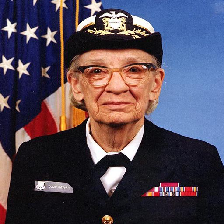

In [38]:
# try a single image
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [0]:
#grace_hopper = np.array(grace_hopper)
#grace_hopper

In [40]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape
#grace_hopper

(224, 224, 3)

In [41]:
# add a batch dimenson, and pass the image to the model
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [42]:
# top class id can be found with argmax
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [0]:
# decode prediction
# class ID telah diprediksi, ambil image label, dan decode prediksi
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

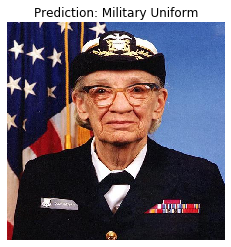

In [44]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [47]:
# simple transfer learning
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [48]:
# rescale
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [49]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [50]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [51]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['sulphur-crested cockatoo', 'bee', 'totem pole',
       'sulphur butterfly', 'daisy', 'bee', 'daisy', 'daisy', 'birdhouse',
       'daisy', 'sea urchin', 'feather boa', 'daisy', 'daisy',
       'stone wall', 'macaw', 'buckeye', 'bee', 'ice lolly', 'daisy',
       'bee', 'cardoon', 'daisy', 'chain', 'daisy', 'cardoon', 'umbrella',
       'cardoon', 'pinwheel', 'lemon', 'ant', 'picket fence'],
      dtype='<U30')

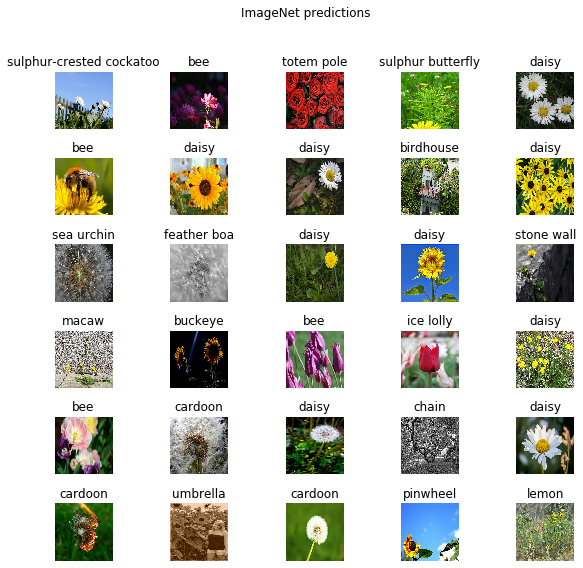

In [52]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [0]:
# download headless model
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [0]:
# create feature extractor
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [55]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
# Freeze the variables in the feature extractor layer, so that the training only
# modifies the new classifier layer.

feature_extractor_layer.trainable = False

In [56]:
# menambah new classification layer
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [58]:
predictions.shape

TensorShape([Dimension(32), Dimension(5)])

In [0]:
# use compile to configurre the training process
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

# https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
# dataset = rows of data
# batch size = untuk sample

Assume you have a dataset with 200 samples (rows of data) and you choose a batch size of 5 and 1,000 epochs.

This means that the dataset will be divided into 40 batches, each with five samples. The model weights will be updated after each batch of five samples.

This also means that one epoch will involve 40 batches or 40 updates to the model.

With 1,000 epochs, the model will be exposed to or pass through the whole dataset 1,000 times. That is a total of 40,000 batches during the entire training process.

In [62]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 13s 114ms/step - loss: 0.6951 - acc: 0.8750
Epoch 2/2
115/115 [==============================] - 12s 106ms/step - loss: 0.3376 - acc: 0.8750


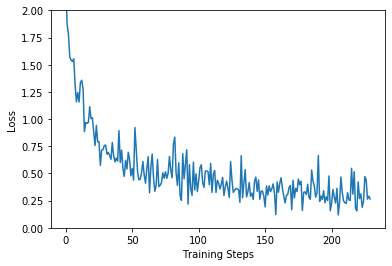

In [63]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

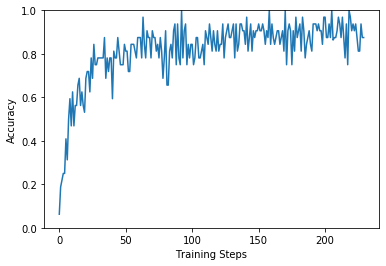

In [64]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [65]:
# check prediction
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [0]:
# run the img batch thru the model & convert them into class names
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
# plot the result
label_id = np.argmax(label_batch, axis=-1)

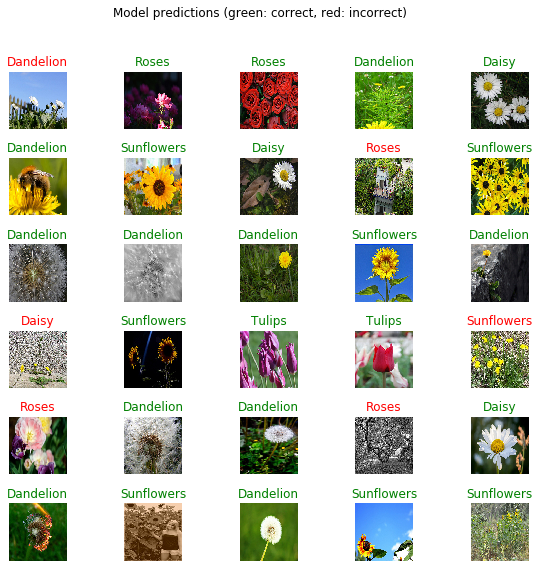

In [68]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [0]:
# export the model
